In [1]:
#%%capture
from pyicecake import pyicecake
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import PIL
from PIL import Image

In [2]:
gc = pyicecake.GPUCache(4*1024*1024*1024) # 4GB

In [3]:
labels_dict = dict()
filenames = []
def convert_image_to_dltensor(image_folder):
    files = []
    with open(image_folder + 'file_list.txt', 'r') as f:
        files = [line.strip() for line in f if line is not '']
    for l in files:
        filename, label = l.split(' ')
#         labels_dict[filename] = cp.asarray(np.array([label], dtype = np.uint8)).toDlpack()
        filenames.append(filename)
        npbuff = np.asarray(PIL.Image.open(image_folder+filename), dtype=np.uint8)
#         cpbuff = cp.asarray(npbuff)
#         dltensor = cpbuff.toDlpack()
        gc.put_numpy_array(filename, npbuff)

In [4]:
convert_image_to_dltensor('/home/lwangay/dali-data/images/')
for f in filenames:
    print(f)

dog/dog_1.jpg
dog/dog_2.jpg
dog/dog_3.jpg
dog/dog_4.jpg
dog/dog_5.jpg
dog/dog_6.jpg
dog/dog_7.jpg
dog/dog_8.jpg
dog/dog_9.jpg
dog/dog_10.jpg
dog/dog_11.jpg
kitten/cat_1.jpg
kitten/cat_2.jpg
kitten/cat_3.jpg
kitten/cat_4.jpg
kitten/cat_5.jpg
kitten/cat_6.jpg
kitten/cat_7.jpg
kitten/cat_8.jpg
kitten/cat_9.jpg
kitten/cat_10.jpg


In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
def show_all_imgs(imgs):
    _, axs = plt.subplots(5, 4, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img)
    plt.show()

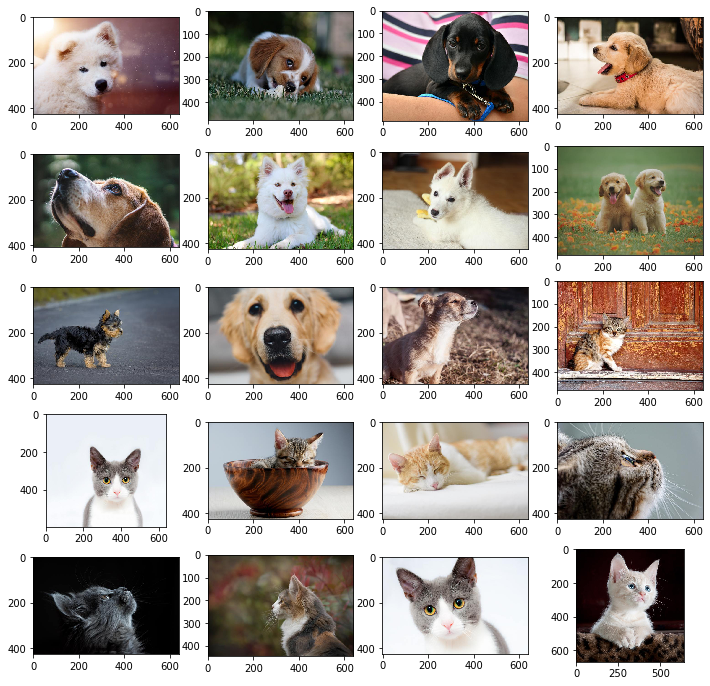

In [6]:
imgs = []
for f in filenames:
    npbuff = gc.get_numpy_array(f)
    img = PIL.Image.fromarray(npbuff)
    imgs.append(img)
show_all_imgs(imgs)
    



In [7]:
type(gc.get_self_pointer())
print(gc.get_self_pointer())

93959271154880


In [8]:
batch_size = 4
class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.files = filenames

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []
        for _ in range(self.batch_size):
            batch.append(filenames[self.i])
#             labels.append(labels_dict[filenames[self.i]])
            self.i = (self.i + 1) % self.n
        return batch

    next = __next__

In [9]:
eii = ExternalInputIterator(batch_size)
iterator = iter(eii)

In [10]:
def read_from_icecake():
    ret = iterator.next()
    for f in ret:
        print(f)
        dltensor = gc.get_dltensor(f, 0)
        return dltensor

class ExternalSourcePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(ExternalSourcePipeline, self).__init__(batch_size,num_threads,device_id,exec_async=False,
                                             exec_pipelined=False,seed=12)
        self.read_from_icecake = ops.DLTensorPythonFunction(function=read_from_icecake, device='gpu', 
                                              synchronize_stream=True, batch_processing=False)
        self.rotate = ops.Rotate(device='gpu')
        self.rng = ops.Uniform(range = (-30.0, 30.0))
        self.crop = ops.RandomResizedCrop(device='gpu', size=[200,200])
    def define_graph(self):
        res = self.read_from_icecake()
        res = self.crop(res)
        angle = self.rng()
        res = self.rotate(res, angle=angle)
        return res



In [11]:
pipe = ExternalSourcePipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()
pipe_out = pipe.run()
pipe_out

dog/dog_1.jpg
dog/dog_5.jpg
dog/dog_9.jpg
kitten/cat_2.jpg


(<nvidia.dali.backend_impl.TensorListGPU at 0x7f390d39a730>,)

kitten/cat_6.jpg
kitten/cat_10.jpg
dog/dog_4.jpg
dog/dog_8.jpg
kitten/cat_1.jpg
kitten/cat_5.jpg
kitten/cat_9.jpg
dog/dog_3.jpg
dog/dog_7.jpg
dog/dog_11.jpg
kitten/cat_4.jpg
kitten/cat_8.jpg
dog/dog_2.jpg
dog/dog_6.jpg
dog/dog_10.jpg
kitten/cat_3.jpg
kitten/cat_7.jpg
dog/dog_1.jpg
dog/dog_5.jpg
dog/dog_9.jpg
kitten/cat_2.jpg
kitten/cat_6.jpg
kitten/cat_10.jpg
dog/dog_4.jpg
dog/dog_8.jpg
kitten/cat_1.jpg
kitten/cat_5.jpg
kitten/cat_9.jpg
dog/dog_3.jpg
dog/dog_7.jpg
dog/dog_11.jpg
kitten/cat_4.jpg
kitten/cat_8.jpg
dog/dog_2.jpg
dog/dog_6.jpg
dog/dog_10.jpg
kitten/cat_3.jpg
kitten/cat_7.jpg
dog/dog_1.jpg
dog/dog_5.jpg
dog/dog_9.jpg
kitten/cat_2.jpg
kitten/cat_6.jpg
kitten/cat_10.jpg
dog/dog_4.jpg
dog/dog_8.jpg
kitten/cat_1.jpg
kitten/cat_5.jpg
kitten/cat_9.jpg
dog/dog_3.jpg
dog/dog_7.jpg
dog/dog_11.jpg
kitten/cat_4.jpg
kitten/cat_8.jpg
dog/dog_2.jpg
dog/dog_6.jpg
dog/dog_10.jpg
kitten/cat_3.jpg
kitten/cat_7.jpg
dog/dog_1.jpg
dog/dog_5.jpg
dog/dog_9.jpg
kitten/cat_2.jpg
kitten/cat_6.jpg
ki

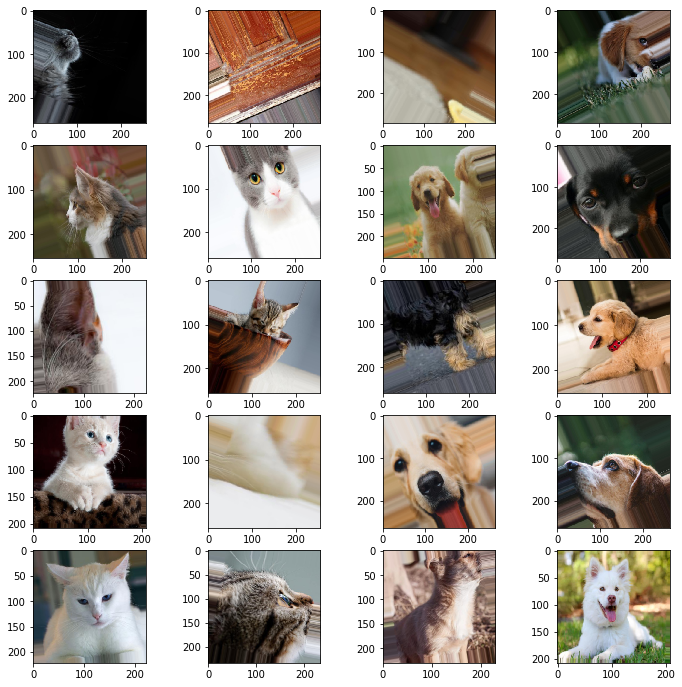

In [12]:
imgs = []
for i in range(0, 20):
    pipe_out = pipe.run()
    im, = pipe_out
    img=im.as_cpu().at(0)
    imgs.append(img)
    
show_all_imgs(imgs)
    

In [13]:
gc.save_dltensor_to_file("dog/dog_1.jpg", "dog_1.tensor")

In [14]:
type(read_from_icecake)

function

In [15]:
gc2 = pyicecake.GPUCache(4*1024*1024*1024) # 4GB

In [16]:
gc2.load_dltensor_from_file("dog_1.tensor")

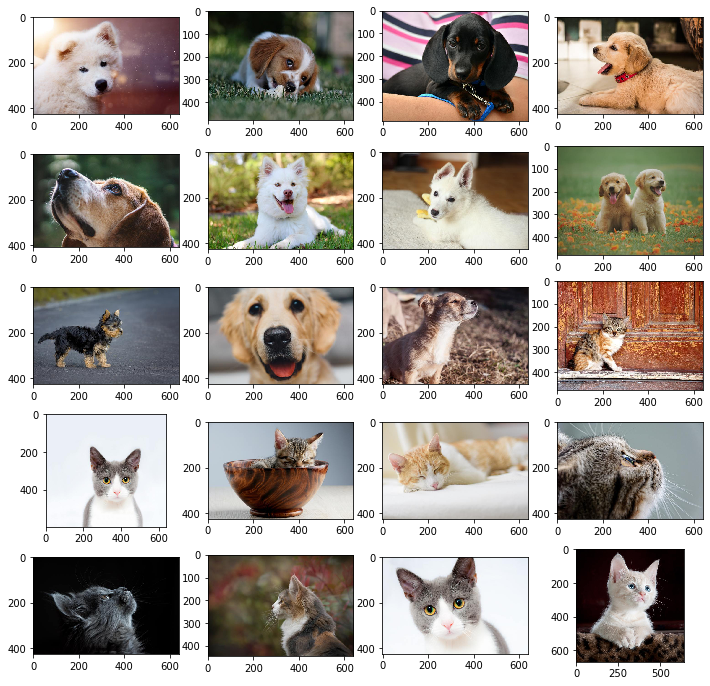

In [17]:
imgs = []
for i in range(20):
    npbuff = gc.get_numpy_array(filenames[i % len(filenames)])
    img = PIL.Image.fromarray(npbuff)
    imgs.append(img)
show_all_imgs(imgs)

In [18]:
import nvidia.dali.plugin_manager as plugin_manager
import os

In [19]:
print(os.path.dirname(pyicecake.__file__))

/home/lwangay/anaconda3/envs/st-dev/lib/python3.7/site-packages/pyicecake/lib


In [20]:
%ls /home/lwangay/anaconda3/envs/st-dev/lib/python3.7/site-packages/pyicecake/lib

libdali_icecake.so*  pyicecake.cpython-37m-x86_64-linux-gnu.so*
libicecake_c.so*


In [21]:
plugin_manager.load_library(os.path.dirname(pyicecake.__file__)+"/libdali_icecake.so")

In [22]:
help(ops.DaliIcecake)

Help on class DaliIcecake in module nvidia.dali.ops:

class DaliIcecake(builtins.object)
 |  DaliIcecake(**kwargs)
 |  
 |  Make a copy of the input tensor
 |  
 |  This operator will **not** be optimized out of the graph.
 |  
 |  Supported backends
 |   * 'cpu'
 |   * 'gpu'
 |  
 |  
 |  Keyword args
 |  ------------
 |  `GPUCacheObjAddr` : int
 |      GPUCache Python Object
 |  `bytes_per_sample_hint` : int, optional, default = 0
 |      Output size hint (bytes), per sample. The memory will be preallocated if it uses GPU or page-locked memory
 |  `preserve` : bool, optional, default = False
 |      Do not remove the Op from the graph even if its outputs are unused.
 |  `seed` : int, optional, default = -1
 |      Random seed (If not provided it will be populated based on the global seed of the pipeline)
 |  
 |  Methods defined here:
 |  
 |  __call__(self, *inputs, **kwargs)
 |      __call__(**kwargs)
 |      
 |      Operator call to be used in `define_graph` step. This operator d

In [39]:
gc.config_shuffle(True)
class CustomOperatorPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(CustomOperatorPipeline, self).__init__(batch_size,num_threads,device_id,seed=12)
        self.read_from_icecake = ops.DaliIcecake(GPUCacheObjAddr=gc.get_self_pointer(), device='gpu')
        self.rotate = ops.Rotate(device='gpu')
        self.rng = ops.Uniform(range = (-30.0, 30.0))
        self.crop = ops.RandomResizedCrop(device='gpu', size=[200,200])
    def define_graph(self):
        res = self.read_from_icecake()
#         res = self.crop(res)
#         angle = self.rng()
#         res = self.rotate(res, angle=angle)
        return res


In [40]:
pipe = CustomOperatorPipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

In [41]:
pipe_out, = pipe.run()
pipe_out

In [42]:
cpu=pipe_out.as_cpu()
cpu.at(0)

array([[[ 25,  14,  12],
        [ 25,  14,  12],
        [ 25,  14,  12],
        ...,
        [ 66,  49,  31],
        [ 66,  49,  31],
        [ 66,  49,  31]],

       [[ 24,  13,  11],
        [ 24,  13,  11],
        [ 24,  13,  11],
        ...,
        [ 66,  49,  31],
        [ 66,  49,  31],
        [ 66,  49,  31]],

       [[ 24,  13,  11],
        [ 24,  13,  11],
        [ 24,  13,  11],
        ...,
        [ 65,  48,  30],
        [ 65,  48,  30],
        [ 65,  48,  30]],

       ...,

       [[195, 195, 187],
        [195, 195, 187],
        [196, 196, 188],
        ...,
        [193, 191, 170],
        [190, 188, 167],
        [189, 187, 166]],

       [[200, 200, 192],
        [200, 200, 192],
        [200, 200, 192],
        ...,
        [191, 189, 168],
        [189, 187, 166],
        [188, 186, 165]],

       [[202, 202, 194],
        [202, 202, 194],
        [203, 203, 195],
        ...,
        [189, 187, 166],
        [188, 186, 165],
        [188, 186, 165]]

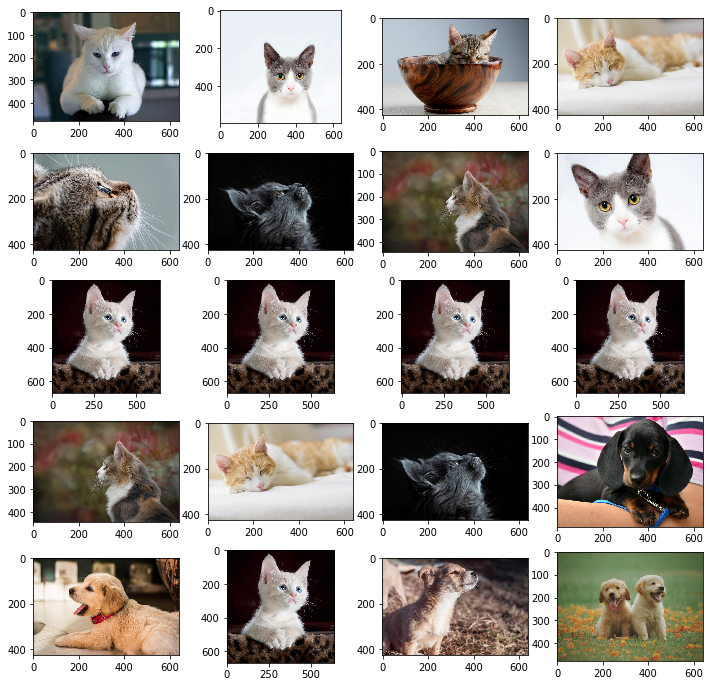

In [43]:
imgs = []
for i in range(0, 5):
    pipe_out = pipe.run()
    im, = pipe_out
    cpu = im.as_cpu()
    for b in range(batch_size):
        imgs.append(cpu.at(b))
    
show_all_imgs(imgs)